### 회귀 실습 - 자전거 대여 수요 예측

##### 데이터 개요 
- 해당 데이터 세트에는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격
동안의 자전거 대여 횟수가 기재돼 있다. 

##### 목표
- 데이터 세트를 이용해 모델을 학습한 후 대여 횟수(count)를 예측한다.

##### 데이터 세트의 주요 칼럼
- datatime: hourly date + timestamp
- season: 1=봄, 2=여름, 3=가을, 4=겨울
- holiday: 1=토,일요일의 주말을 제외한 국경일 등의 휴일, 0=휴일이 아닌 날
- workingday: 1=토,일요일의 주말 및 휴일이 아닌 주중, 0=주말 및 휴일
- weather: 1=맑음, 약간 구름 낀 흐림, 2=안개, 안개+흐림, 3=가벼운 눈, 가벼운 비+천둥, 4=심한 눈/비, 천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대습도
- windspeed: 풍속
- casual: 사전에 등록되지 않는 사용자가 대여한 횟수
- registered: 사전에 등록된 사용자가 대여한 횟수
- count: 대여 횟수

### 데이터 클렌징 및 가공

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

bike_df = pd.read_csv('./dataset/bike_train.csv')
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
# 데이터 세트는 10886개의 레코드와 12개의 칼럼으로 구성되어 있다.
bike_df.shape

(10886, 12)

In [4]:
# Null값 데이터는 없으며, 대부분 칼럼이 int 또는 float 숫자형이다.
# datetime 칼럼만 object형이다.
# Datetime 칼럼의 경우 년-월-일 시:분:초 문자 형식으로 되어있으므로 이에 대한 가공이 필요하다.
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
# datetime을 년, 월, 일, 시간 분, 초로 편리하게 변환하려면 먼저 문자열을 datetime으로 변경해야한다.
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime type에서 년, 월, 일, 시간 추출하여 새로운 칼럼 생성
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [6]:
# datetime 바뀐것 확인
bike_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

In [ ]:
# casual 칼럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수
# registered는 사전에 등록한 사용자의 대여 횟수
# count = casual + registered 이므로 casual와 registered 삭제한다 -> why? 상관도가 높아 예측을 저해할 우려가 있기 때문
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

In [12]:
# 다양한 회귀 모델을 데이터 세트에 적용해 예측 성능을 측정
# 성능 평가 방법은 RMSLE(Root Mean Square Log Error) -> RMSE에 LOG 취한 값
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2 # 실제값 - 예측값의 제곱
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가
- 회귀 모델을 적용 하기 전에 데이터 세트에 대해서 먼저 처리해야 할 사항이 있다.
    - 결괏값이 정규 분포로 되어 있는지 확인하는 한다.
    - 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩 해야 한다.

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count'] # 대여 횟수(종속변수)
X_features = bike_df.drop(['count'], axis=1, inplace=False) # 대여 횟수 제외한 독립변수들

# 학습 데이터, 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

# LinearRegression 객체를 이용해 회귀 예측
lr_reg = LinearRegression()
# 학습
lr_reg.fit(X_train, y_train)
# 예측
pred = lr_reg.predict(X_test)
# 평가
evaluate_regr(y_test, pred)

# RMSLE는 log1p() 이용 -> 1+log()값으로 log 변환값에 1을 더하므로써 오버플로/언더플로 오류 해결
# RMSLE: 1.165, RMSE: 140.900, MAE: 105.924는 실제 Target 데이터 값인 대여 횟수(count)를 감안하면 예측 오류로서는 비교적 큰 값이다.

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [17]:
# 실제 값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류값 TOP5 확인
def get_top_error_data(y_test, pred, n_tops= 5):
    
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count']) # 실제 값
    result_df['predicted_count'] = np.round(pred) # 예측 값
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count']) # 차이 값
    
    
# 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops=5)

# 가장 큰 상위 5위 오류 값은 546 ~ 568로 실제 값을 감안하면 예측 오류가 꽤 크다.
# 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target값의 분포가 왜곡된 형태를 이루고 있는지 확인 하는 것이다. 
# Target 값의 분포는 정규 분포 형태가 가장 좋다.
# 그렇지 않고 왜곡된 경우에는 회귀 예측 성능이 저하되는 경우가 발생하기 쉽다.

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

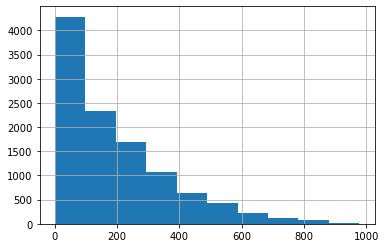

In [22]:
# DataFrame의 hist()를 이용해 자전거 대여 모델의 Target 값인 count 칼럼이 정규 분포를 이루는지 확인
y_target.hist()

# count 칼럼 값이 정규 분포가 아닌 0 ~ 200 사이에 왜곡 되어 있는 것을 확인 할 수 있다.
# 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것이다.

<AxesSubplot:>

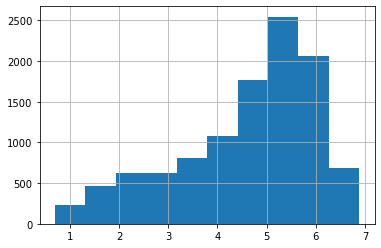

In [23]:
# log1p()를 이용하여 로그 변환 후 변경된 Target 값을 기반으로 학습하고 예측
# 예측 한 값은 다시 expm1() 함수를 적용해 원래 scale값으로 원상 복구한다.

# log1p()를 적용한 'count'값의 분포를 확인
y_log_transform = np.log1p(y_target)
y_log_transform.hist()
# 로그로 Target 값을 변환한 후에 원하는 정규 분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상됨

In [24]:
# Target 칼럼인 count 값을 1og1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size= 0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
# np.expm1은 각 요소에 자연상수를 밑으로 하는 지수함수를 적용한 뒤 1을 뺀 값이다.
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습되어 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

# RMSLE 오류는 줄어들었지만, RMSE는 오히려 더 늘어났다 -> why? 

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<AxesSubplot:>

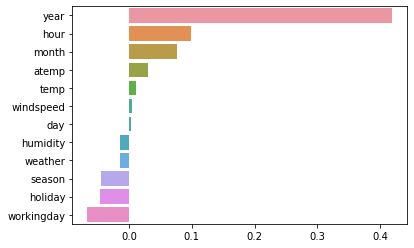

In [25]:
# 각 피처의 회귀 계수 값을 시각화
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x = coef_sort.values, y = coef_sort.index)

##### 시각화 해석
- Year 피처의 회귀 계수 값이 독보적으로 큰 값을 가지고 있다.
- year는 2011년, 2012년 두 개의 값으로 되어 있다.
- year에 따라서 자전거 대여 횟수가 크게 영향을 받는다는 것은 납득하기 어렵다.<br><br>
그렇다면 여름, 가을과 같이 자전거를 타기 좋은 계절이나 낮 시간대 등의 다양한 요소를 제외하고 year의 회귀 계수가 이렇게 큰 이유는 무엇일까? <br><br>
- year 피처는 연도를 뜻하므로 카테고리형 피처지만, 숫자형 값으로 되어있다. 더군다나 아주 큰 값인 2011, 2012로 되어 있다. 
- 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해줘야 한다.
- 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있으므로 원-핫 인코딩을 적용해 변환해야 한다.

In [35]:
# 'year', 'month', 'day', 'hour' 등의 피처를 One-Hot Encoding
# get_dummies를 사용해 범주형 변수를 -> 연속형 변수로 바꾸어준다.
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday',
                                                    'workingday', 'season','weather'])

In [33]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_exmp1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_exmp1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    
# end of function get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_exmp1=True)
    
# 원-핫 인코딩 적용하고 나서 선형 회귀의 예측 성능이 많이 향상됐다.
# 원-핫 인코딩된 데이터세트에서 회귀 계수가 높은 피처를 다시 시각화한다.

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<AxesSubplot:>

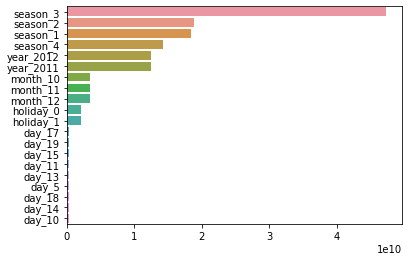

In [30]:
# 회귀 계수 상위 25개 피처를 추출
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [37]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)


for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]: 
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_exmp1=True)
    
# RMSE 에러를 제곱하여 평균한 값에 루트씌움 -> 값이 낮을 수록 좋다

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.059, MAE: 31.058
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.348, MAE: 32.744
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
